In [1]:
#checking we are working on the right virtual environment

In [2]:
import sys
sys.executable
#!pip3 freeze > requirements.txt

'/Users/federicojacopobaldoni/Documents/LUISS/machine_learning/pino_env/bin/python3'

In [3]:
#importing packages

In [4]:
import numpy as np
import pandas as pd

from ydata_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns

# EDA

importing dataset

In [5]:
df = pd.read_csv('./Project datasets-20230327/flight_dataset.csv', index_col=0)
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


resetting index, just to be sure

In [6]:
df.reset_index(inplace=True)

In [7]:
#profile = ProfileReport(df, title="FLIGHTS - Pandas Profiling Report", explorative=True)
#profile.to_file("flights.html")

checking for nans

In [8]:
df.isna().sum()

index               0
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

checking for duplicates

In [9]:
df.duplicated().sum()

0

In [10]:
########
########

## PRICE

looking at price distribution

Text(0.5, 1.0, 'PRICE HISTOGRAM')

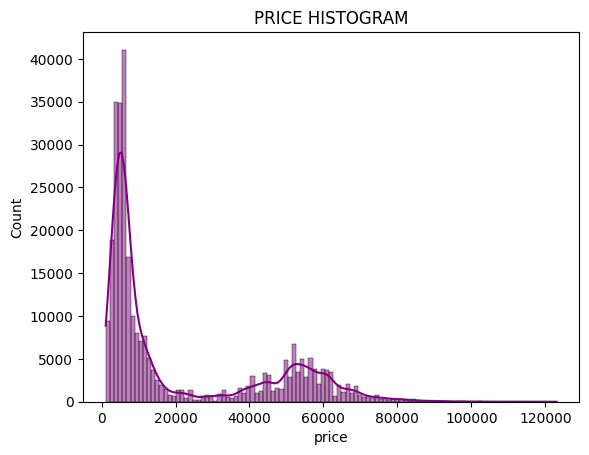

In [11]:
sns.histplot(data=df, x='price', kde=True, color='purple')
plt.title('PRICE HISTOGRAM')

price seems to be pretty skewed

we'll probably have to work on it later

In [12]:
#########
########

### CITIES

price boxplots on source and destionation cities

[Text(0.5, 1.0, 'BOXPLOT PRICE - DESTINATION CITY')]

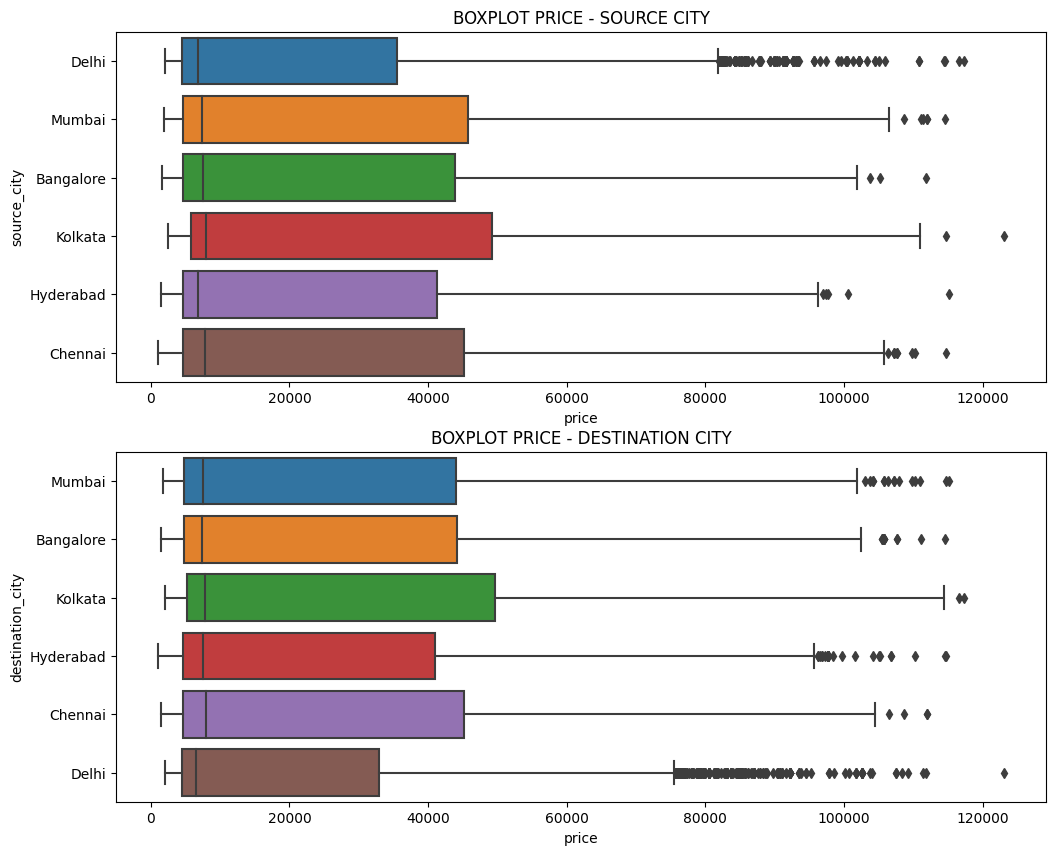

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(12,10))

g1 = sns.boxplot(data=df, x='price', y='source_city', ax=axs[0])
g1.set(title = 'BOXPLOT PRICE - SOURCE CITY')

g2 = sns.boxplot(data=df, x='price', y='destination_city', ax=axs[1])
g2.set(title = 'BOXPLOT PRICE - DESTINATION CITY')

In [14]:
########
########

### STOPS

price boxplots on the number of stops made

Text(0.5, 1.0, 'BOXPLOT PRICE - STOPS')

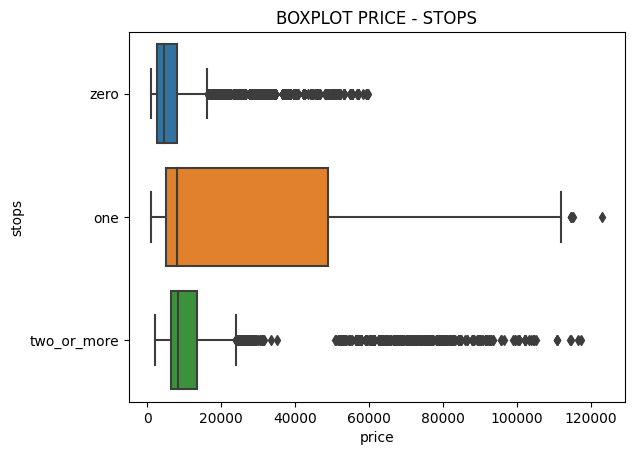

In [15]:
sns.boxplot(data=df, x='price', y='stops')
plt.title('BOXPLOT PRICE - STOPS')

interestingly zero stops flights tend to be the more economic ones, this may be due to the fact that they make smaller voyages


two or more stops have a lot of outliers, may that be last minute flights?

In [16]:
#########
#########

### ARRIVAL TIME

price boxplots on the arrival time

Text(0.5, 1.0, 'BOXPLOT PRICE - ARRIVAL TIME')

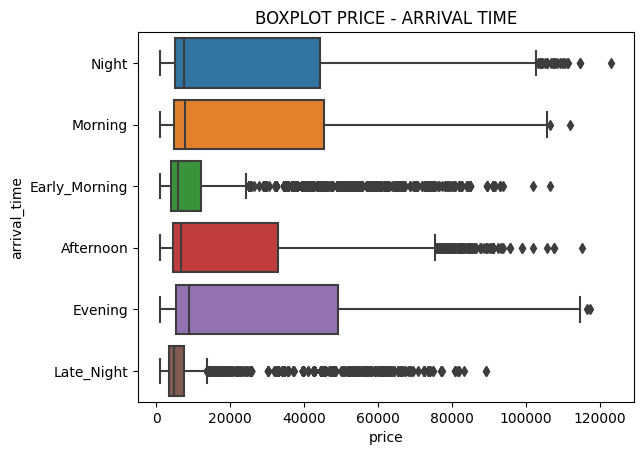

In [17]:
sns.boxplot(data=df, x='price', y='arrival_time')
plt.title('BOXPLOT PRICE - ARRIVAL TIME')

as expected the most economic flights are the one that arrive at destination in the late night or early in the morining

also afternoon flights is reasonable that are a little cheaper than the reaming arrival time

In [18]:
########
########

### CLASS

price boxplots on class

Text(0.5, 1.0, 'BOXPLOT PRICE - CLASS')

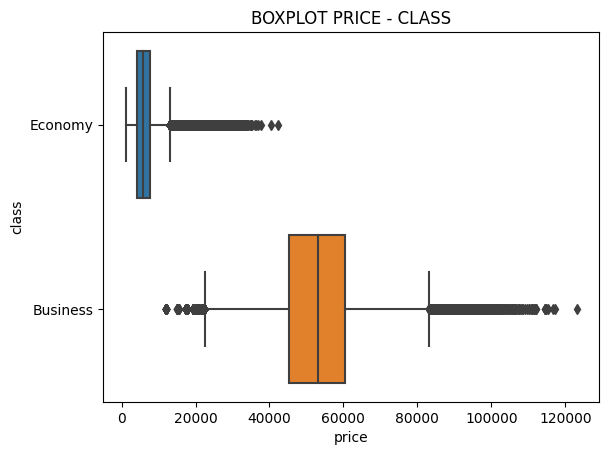

In [19]:
sns.boxplot(data=df, x='price', y='class')
plt.title('BOXPLOT PRICE - CLASS')

well.. as exepcted economy flights are cheaper

In [20]:
########
########

### DURATION

price - duration scatterplot

Text(0.5, 1.0, 'SCATTERPLOT PRICE - DURATION')

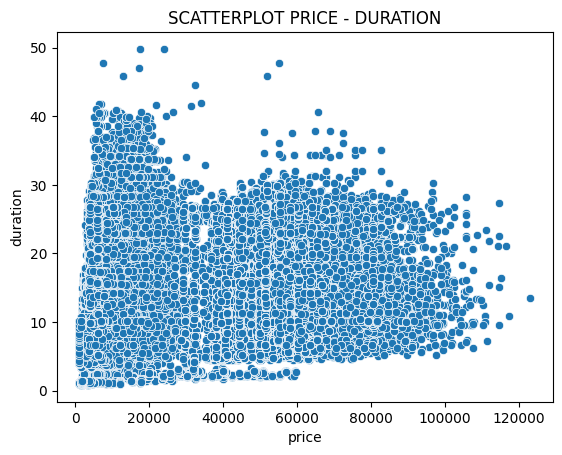

In [22]:
sns.scatterplot(data=df, x='price', y='duration')
plt.title('SCATTERPLOT PRICE - DURATION')

paradoxaly longer duration flights are not the more expensive